## Demo notebook on how to train word2vec embeddings following the negative sampling training procedure proposed by Mikolov et. al.;
* The word embeddings are trained on the WikiText2 training dataset;
* This is a notebook that was obtained by traning on Google Colab (GPU runtime hence the `.to(device)` statements).

In [1]:
!pip install torch==1.9
!pip install torchtext==0.10

In [2]:
import numpy as np
import torch
import sys
sys.path.append("../preprocessing")
from torch import nn
import random
import get_data as gd
import word2vec_NEG as w2v_neg
import pickle
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

### Get `torch.utils.data.DataLoader` and `vocab.Vocab` objects;

In [3]:
vocab_min_freq, num_negatives = 5, 15
max_window_size, shuffle = 4, True
loader, vocab = gd.get_wikitext2_data_neg("../data", vocab_min_freq=vocab_min_freq,
                                          num_negatives=num_negatives, 
                                          max_window_size=max_window_size,
                                          shuffle=shuffle)

In [4]:
print(f"size of WikiText2 vocab is: {len(vocab)}")

size of WikiText2 vocab is: 17027


### Set up the model;

In [5]:
def log_sigmoid(x):
    return torch.log(1 / (1 + torch.exp(- x)))

In [6]:
class EmbeddingsModelNEG(nn.Module):
    def __init__(self, vocab_size, embed_size, **kwargs):
        super(EmbeddingsModelNEG, self).__init__(**kwargs)
        self.embed_center = nn.Embedding(vocab_size, embed_size)
        self.embed_context = nn.Embedding(vocab_size, embed_size)
    
    def forward(self, centers, contexts_and_negatives, coefficients):
        V = self.embed_center(centers)
        U = self.embed_context(contexts_and_negatives)
        return torch.bmm(V, U.permute(0, 2, 1)) * coefficients.unsqueeze(1)

### Instantiate a model object and initialise weights from Xavier Normal;

In [7]:
def init_weights(m):
  if type(m) == nn.Embedding:
    nn.init.xavier_normal_(m.weight.data)

In [8]:
vocab_size, embed_size = len(vocab), 100
model = EmbeddingsModelNEG(vocab_size, embed_size)

In [9]:
model.apply(init_weights)

EmbeddingsModelNEG(
  (embed_center): Embedding(17027, 100)
  (embed_context): Embedding(17027, 100)
)

### Get the model on the device;

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"I will be using {device}")

I will be using cuda


In [11]:
model.to(device)

EmbeddingsModelNEG(
  (embed_center): Embedding(17027, 100)
  (embed_context): Embedding(17027, 100)
)

### Setup the loss;

In [12]:
class EmbeddingLossNEG(nn.Module):
    def __init__(self):
        super(EmbeddingLossNEG, self).__init__()
    
    def forward(self, prods, mask_pads):
        return - (log_sigmoid(prods.squeeze(1)) * mask_pads).sum()

In [13]:
loss_fn = EmbeddingLossNEG()

### Optimise with Adam and use a learning rate schedule every 25 epochs;

In [14]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=25, gamma=0.5)

### Define train loop for 1 epoch;

In [15]:
def train_loop(model, loss_fn, optim, loader, device):
    model.train()
    fifth = max(1, len(loader) // 5)
    batches = len(loader)
    tot_loss = 0.
    for batch, (centers, contexts_and_negatives, coefficients, 
                mask_pads) in enumerate(loader, start=1):
        prods = model(centers.to(device), contexts_and_negatives.to(device), 
                      coefficients.to(device))
        loss = loss_fn(prods,  mask_pads.to(device))
        if batch % fifth == 0:
            print(f"train_loss: {loss.item():.5f}\tprogress: {batch}/{batches}")
        tot_loss += loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
    print(f"total train loss: {tot_loss:.5f}")

### Start training;

In [16]:
for t in range(50):
    print(f"Epoch {t+1}:\n-------------------------")
    train_loop(model, loss_fn, optim, loader, device)
    print(f"last lr: {scheduler.get_last_lr()[0]}")
    scheduler.step()
    print('\n')

Epoch 1:
-------------------------
train_loss: 18967.20898	progress: 148/742
train_loss: 12206.65918	progress: 296/742
train_loss: 9638.41309	progress: 444/742
train_loss: 8689.46094	progress: 592/742
train_loss: 8070.04053	progress: 740/742
total train loss: 9960995.42358
last lr: 0.001


Epoch 2:
-------------------------
train_loss: 8105.89453	progress: 148/742
train_loss: 7931.19873	progress: 296/742
train_loss: 7789.23828	progress: 444/742
train_loss: 8040.39551	progress: 592/742
train_loss: 8052.84473	progress: 740/742
total train loss: 5933464.21240
last lr: 0.001


Epoch 3:
-------------------------
train_loss: 8106.81006	progress: 148/742
train_loss: 8340.44141	progress: 296/742
train_loss: 7983.03223	progress: 444/742
train_loss: 7953.59912	progress: 592/742
train_loss: 7777.04980	progress: 740/742
total train loss: 5879412.30713
last lr: 0.001


Epoch 4:
-------------------------
train_loss: 8137.30518	progress: 148/742
train_loss: 8166.66797	progress: 296/742
train_loss: 77

In [17]:
# save embeds after 50 epochs;
embeds_centers_50e = model.embed_center.weight.data.cpu().numpy()
embeds_contexts_50e = model.embed_context.weight.data.cpu().numpy()

In [18]:
for t in range(50, 100):
    print(f"Epoch {t+1}:\n-------------------------")
    train_loop(model, loss_fn, optim, loader, device)
    print(f"last lr: {scheduler.get_last_lr()[0]}")
    scheduler.step()
    print('\n')

Epoch 51:
-------------------------
train_loss: 3548.85376	progress: 148/742
train_loss: 3489.54858	progress: 296/742
train_loss: 3606.64453	progress: 444/742
train_loss: 3235.06104	progress: 592/742
train_loss: 3478.25195	progress: 740/742
total train loss: 2574836.58459
last lr: 0.00025


Epoch 52:
-------------------------
train_loss: 3268.33276	progress: 148/742
train_loss: 3404.49146	progress: 296/742
train_loss: 3515.64111	progress: 444/742
train_loss: 3495.95923	progress: 592/742
train_loss: 3672.35327	progress: 740/742
total train loss: 2568276.71997
last lr: 0.00025


Epoch 53:
-------------------------
train_loss: 3470.86035	progress: 148/742
train_loss: 3530.40527	progress: 296/742
train_loss: 3291.43481	progress: 444/742
train_loss: 3445.16260	progress: 592/742
train_loss: 3453.53931	progress: 740/742
total train loss: 2562036.99976
last lr: 0.00025


Epoch 54:
-------------------------
train_loss: 3258.55908	progress: 148/742
train_loss: 3563.06787	progress: 296/742
train_

In [19]:
# save embeds after 100 epochs;
embeds_centers_100e = model.embed_center.weight.data.cpu().numpy()
embeds_contexts_100e = model.embed_context.weight.data.cpu().numpy()

### Serialize the embeddings (both center and context) as `numpy` objects;

In [20]:
np.save("w2v_embeds_wikitext2_centers_100e.npy", embeds_centers_100e)
np.save("w2v_embeds_wikitext2_contexts_100e.npy", embeds_contexts_100e)

### Import embeddings and check some similarities;

In [21]:
with open("w2v_embeds_wikitext2_centers_100e.npy", 'rb') as f:
    embeds_centers = np.load(f)
    embeds_centers_t = torch.tensor(embeds_centers, requires_grad=False)

In [22]:
# some nice biology analogies;
scores, idxs = w2v_neg.get_close_words("mrna", embeds_centers_t, vocab, k=8)
print(scores.reshape(-1))
print(vocab.convert_to_token(idxs.reshape(-1).tolist()))

tensor([1.0000, 0.5405, 0.5398, 0.5368, 0.5197, 0.5151, 0.5131, 0.5076])
['mrna', 'cellular', 'structural', 'chromatin', 'transcriptional', 'nucleoplasm', 'rna', 'subunits']


In [23]:
# very popular topic these days;
scores, idxs = w2v_neg.get_close_words("viruses", embeds_centers_t, vocab, k=8)
print(scores.reshape(-1))
print(vocab.convert_to_token(idxs.reshape(-1).tolist()))

tensor([1.0000, 0.5536, 0.5158, 0.5046, 0.5006, 0.4921, 0.4857, 0.4727])
['viruses', 'synthesize', 'eukaryotes', 'replication', 'protein', 'chromatin', 'transcriptional', 'extracted']


### Let's inspect some combinations of vectors;

In [24]:
v = embeds_centers_t[vocab["woman"]] + embeds_centers_t[vocab["army"]]
cos_sims = (embeds_centers_t @ v.reshape(-1, 1)) / (torch.sqrt((embeds_centers_t \
                                                   * embeds_centers_t).sum(1)).reshape(-1, 1) \
                                                   * torch.sqrt((v * v).sum()))
scores, idxs = torch.topk(cos_sims, k=8, dim=0)

In [25]:
print(scores.reshape(-1))
print(vocab.convert_to_token(idxs.reshape(-1).tolist()))

tensor([0.7414, 0.7373, 0.4589, 0.4533, 0.4511, 0.4435, 0.4429, 0.4411])
['woman', 'army', 'cults', 'inauguration', 'sniper', 'parole', 'qedarite', 'commanded']


### See some low-dim visualisations of the w2v embeddings;

In [26]:
# get center words;
center_samples = torch.tensor(random.sample(list(range(vocab.num_special_tokens, 
                                                       len(vocab))), k=50))
named_center_samples = vocab.convert_to_token(center_samples.tolist())
center_vectors = embeds_centers_t[center_samples]
# get close words for the centers;
all_close_ones = []
# get close words for each center;
for word in named_center_samples:
    scores, idxs = w2v_neg.get_close_words(word, embeds_centers_t, vocab, k=5)
    # pick contexts with at least 0.45 cosine similarity;
    idxs = [idx.item() for score, idx in zip(scores, idxs) if score >= 0.45]
    # the first element is the center itself, so skip it;
    all_close_ones += idxs[1:]  
# get the vectors of close words and map the indeces of close words
# to strings;
close_vectors = embeds_centers_t[all_close_ones]
named_close_ones = vocab.convert_to_token(all_close_ones)

### Setup `TSNE` embeds;

In [27]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use(["ggplot", "dark_background"])

In [28]:
all_vectors = torch.cat((center_vectors, close_vectors), dim=0)
print(all_vectors.shape)

torch.Size([158, 100])


In [29]:
tsne = TSNE(random_state=42)

In [30]:
output = tsne.fit_transform(all_vectors.detach().numpy())

In [31]:
centers = output[:50]
close_ones = output[50:]

### Plot the data;

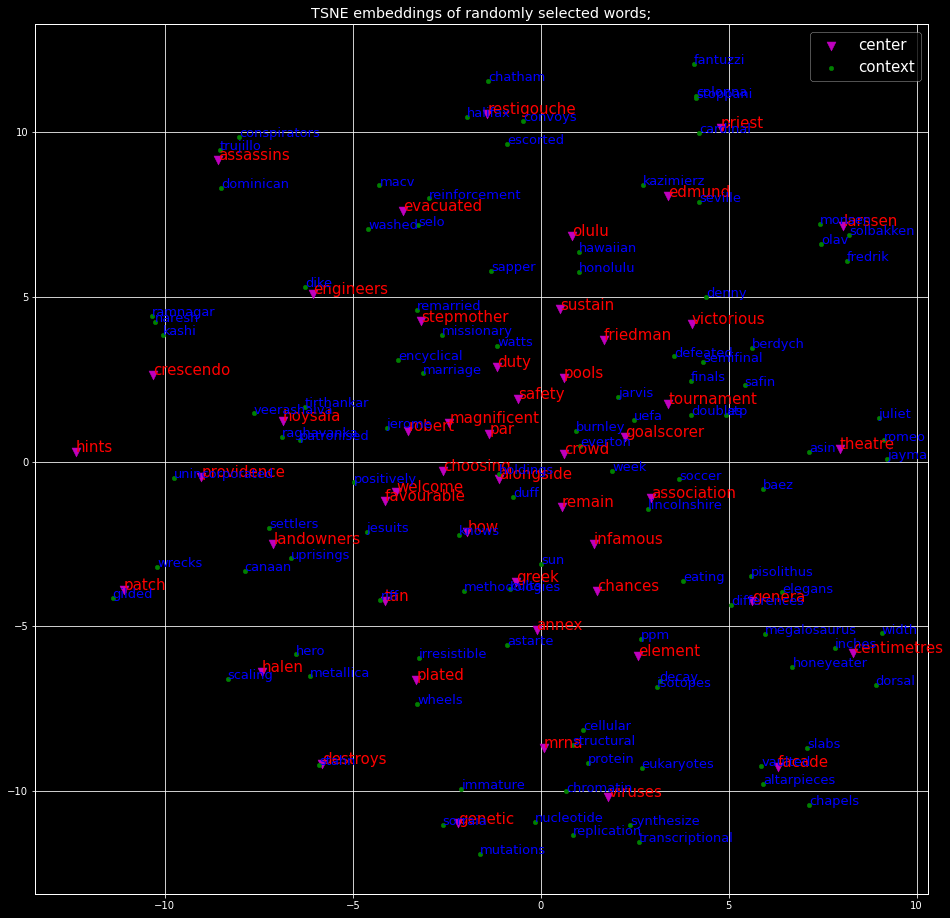

In [32]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.scatter(centers[:,0], centers[:, 1], color='m', marker='v', s=80)
ax.scatter(close_ones[:, 0], close_ones[:, 1], color='green', marker='o', s=20)
for i in range(len(output)):
    if i < 50:
        ax.annotate(named_center_samples[i], (centers[i, 0], centers[i, 1]), 
                    color='r', size=15)
    else:
        ax.annotate(named_close_ones[i - 50], (close_ones[i-50, 0], close_ones[i-50, 1]), 
                    color='b', size=13)
ax.set_title("TSNE embeddings of randomly selected words;")
plt.legend(["center", "context"], prop={"size": 15})
plt.show()